In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import nbimporter
import gc

from keras import backend as K 

import tensorflow.compat.v1 as tf

from sklearn.metrics import roc_curve
from scipy import stats
import warnings

Using TensorFlow backend.


Importing Jupyter notebook from get_p_value_correlation_plot.ipynb


In [2]:
# Ignore tensorflow deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
# Prepare GPU environment and define amount of memory to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be used
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.42)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

[]

In [4]:
# Define path to load input data
path = '/home/pablo/Documentos/lbl/olympics/final_runs_safety_data/input_features/'

# Load input features from file
features_filename = path + "all_input_features.hdf5"
h5_results = h5py.File(features_filename, 'r')

# Store features info
signal = h5_results['signal'][:]
h5_results.close()

# Load input features from file
features_filename = path + "signal_features_m300.hdf5"
h5_results = h5py.File(features_filename, 'r')

# Store features info
signal2 = h5_results['signal'][:]
h5_results.close()

# Load extra background
filename = path + "all_input_features_extra_QCD.hdf5"
h5_results = h5py.File(filename, 'r')

# Store reconstruction info
background2 = h5_results['background'][:]

h5_results.close()

In [5]:
print('Signal features shape: %s' % (signal.shape,))
print('Background features shape: %s' % (background2.shape,))

Signal features shape: (100000, 19)
Background features shape: (1000000, 19)


In [6]:
# Check memory used by dataframe
print('Memory used by signal array: %.2f MB' % (signal.nbytes / (10**3 * 1024)))
print('Memory used by background array: %.2f MB' % (background2.nbytes / (10**3 * 1024)))

Memory used by signal array: 7.42 MB
Memory used by background array: 74.22 MB


In [7]:
print('Signal sample event:\n %s' % signal[-1])
print('Background sample event:\n %s' % background2[-1])

Signal sample event:
 [5.2446600e+02 1.0832571e+00 2.5803497e-01 4.5522016e-01 8.3903021e-01
 1.0000000e+02 1.6933600e+03 1.4638700e-01 5.7815900e+00 5.0901700e+02
 2.1395028e+00 6.3921463e-01 4.9157158e-01 7.1343958e-01 8.1000000e+01
 1.6535500e+03 5.6652099e-01 2.5919499e+00 3.5733401e+03]
Background sample event:
 [5.9010303e+02 1.1046650e+00 2.6964295e-01 1.8675022e-01 7.8707391e-01
 6.1000000e+01 1.1812300e+03 3.2658601e-01 2.3538799e+00 4.0277399e+02
 1.9991943e+00 5.6426340e-01 6.1025232e-01 8.1655020e-01 1.0200000e+02
 1.2716801e+03 1.0516300e-01 5.5267401e+00 2.6649043e+03]


In [8]:
# Study each feature of jet 1 before preprocessing data
print('background2:')
print('mj: (min, max) = (%f, %f)' % (background2[:,0].min(), background2[:,0].max()))
print('t2: (min, max) = (%f, %f)' % (background2[:,1].min(), background2[:,1].max()))
print('tau21: (min, max) = (%f, %f)' % (background2[:,2].min(), background2[:,2].max()))
print('tau32: (min, max) = (%f, %f)' % (background2[:,3].min(), background2[:,3].max()))
print('tau43: (min, max) = (%f, %f)' % (background2[:,4].min(), background2[:,4].max()))
print('ntrk: (min, max) = (%i, %i)' % (background2[:,5].min(), background2[:,5].max()))
print('pt: (min, max) = (%i, %i)' % (background2[:,6].min(), background2[:,6].max()))
print('eta: (min, max) = (%i, %i)' % (background2[:,7].min(), background2[:,7].max()))
print('phi: (min, max) = (%i, %i)' % (background2[:,8].min(), background2[:,8].max()))

# Study each feature of jet 1 before preprocessing data
print('SIGNAL:')
print('mj: (min, max) = (%f, %f)' % (signal[:,0].min(), signal[:,0].max()))
print('t2: (min, max) = (%f, %f)' % (signal[:,1].min(), signal[:,1].max()))
print('tau21: (min, max) = (%f, %f)' % (signal[:,2].min(), signal[:,2].max()))
print('tau32: (min, max) = (%f, %f)' % (signal[:,3].min(), signal[:,3].max()))
print('tau43: (min, max) = (%f, %f)' % (signal[:,4].min(), signal[:,4].max()))
print('ntrk: (min, max) = (%i, %i)' % (signal[:,5].min(), signal[:,5].max()))
print('pt: (min, max) = (%i, %i)' % (signal[:,6].min(), signal[:,6].max()))
print('eta: (min, max) = (%i, %i)' % (signal[:,7].min(), signal[:,7].max()))
print('phi: (min, max) = (%i, %i)' % (signal[:,8].min(), signal[:,8].max()))

background2:
mj: (min, max) = (11.942200, 1943.579956)
t2: (min, max) = (0.949067, 18.988918)
tau21: (min, max) = (0.009562, 0.935961)
tau32: (min, max) = (0.073349, 0.969421)
tau43: (min, max) = (0.000000, 0.987687)
ntrk: (min, max) = (4, 287)
pt: (min, max) = (389, 4176)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)
SIGNAL:
mj: (min, max) = (90.230698, 1531.589966)
t2: (min, max) = (0.959416, 6.475880)
tau21: (min, max) = (0.023041, 0.828905)
tau32: (min, max) = (0.071400, 0.949869)
tau43: (min, max) = (0.144222, 0.965875)
ntrk: (min, max) = (11, 233)
pt: (min, max) = (596, 3119)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)


In [9]:
# Study each feature of jet 2 before preprocessing data
print('background2:')
print('mj: (min, max) = (%f, %f)' % (background2[:,9].min(), background2[:,9].max()))
print('t2: (min, max) = (%f, %f)' % (background2[:,10].min(), background2[:,10].max()))
print('tau21: (min, max) = (%f, %f)' % (background2[:,11].min(), background2[:,11].max()))
print('tau32: (min, max) = (%f, %f)' % (background2[:,12].min(), background2[:,12].max()))
print('tau43: (min, max) = (%f, %f)' % (background2[:,13].min(), background2[:,13].max()))
print('ntrk: (min, max) = (%i, %i)' % (background2[:,14].min(), background2[:,14].max()))
print('pt: (min, max) = (%i, %i)' % (background2[:,15].min(), background2[:,15].max()))
print('eta: (min, max) = (%i, %i)' % (background2[:,16].min(), background2[:,16].max()))
print('phi: (min, max) = (%i, %i)' % (background2[:,17].min(), background2[:,17].max()))

# Study each feature of jet 2 before preprocessing data
print('SIGNAL:')
print('mj: (min, max) = (%f, %f)' % (signal[:,9].min(), signal[:,9].max()))
print('t2: (min, max) = (%f, %f)' % (signal[:,10].min(), signal[:,10].max()))
print('tau21: (min, max) = (%f, %f)' % (signal[:,11].min(), signal[:,11].max()))
print('tau32: (min, max) = (%f, %f)' % (signal[:,12].min(), signal[:,12].max()))
print('tau43: (min, max) = (%f, %f)' % (signal[:,13].min(), signal[:,13].max()))
print('ntrk: (min, max) = (%i, %i)' % (signal[:,14].min(), signal[:,14].max()))
print('pt: (min, max) = (%i, %i)' % (signal[:,15].min(), signal[:,15].max()))
print('eta: (min, max) = (%i, %i)' % (signal[:,16].min(), signal[:,16].max()))
print('phi: (min, max) = (%i, %i)' % (signal[:,17].min(), signal[:,17].max()))

background2:
mj: (min, max) = (-0.000031, 1184.410034)
t2: (min, max) = (0.000000, 85.107750)
tau21: (min, max) = (0.000000, 0.946769)
tau32: (min, max) = (0.000000, 0.984744)
tau43: (min, max) = (0.000000, 0.985225)
ntrk: (min, max) = (1, 226)
pt: (min, max) = (312, 4024)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)
SIGNAL:
mj: (min, max) = (-0.000022, 1044.869995)
t2: (min, max) = (0.000000, 52.553703)
tau21: (min, max) = (0.000000, 0.923309)
tau32: (min, max) = (0.000000, 0.948722)
tau43: (min, max) = (0.000000, 0.966906)
ntrk: (min, max) = (1, 194)
pt: (min, max) = (545, 3201)
eta: (min, max) = (-2, 2)
phi: (min, max) = (0, 6)


In [10]:
# Define function to take the input features of the jets

def make_data(jet1_features,jet2_features):
    bgdata_jet1=background2[:,jet1_features]
    bgdata_jet2=background2[:,jet2_features]

    sigdata_jet1=signal[:,jet1_features]
    sigdata_jet2=signal[:,jet2_features]

    sigdata2_jet1=signal2[:,jet1_features]
    sigdata2_jet2=signal2[:,jet2_features]

    bg_mjj = background2[:,18]
    sig_mjj = signal[:,18]
    sig2_mjj=signal2[:,18]

    bgdata_jets=np.hstack((bgdata_jet1,bgdata_jet2))
    sigdata_jets=np.hstack((sigdata_jet1,sigdata_jet2))
    sigdata2_jets=np.hstack((sigdata2_jet1,sigdata2_jet2))

    # restrict mjj to 2800-5200 GeV 
#    bg_mask=(bg_mjj>2800) & (bg_mjj<5200)
#    sig_mask=(sig_mjj>2800) & (sig_mjj<5200)
#    sig2_mask=(sig2_mjj>2800) & (sig2_mjj<5200)
#    
#    bgdata_jets=np.hstack((bgdata_jet1,bgdata_jet2))[bg_mask]
#    sigdata_jets=np.hstack((sigdata_jet1,sigdata_jet2))[sig_mask]
#    sigdata2_jets=np.hstack((sigdata2_jet1,sigdata2_jet2))[sig2_mask]
#    bg_mjj=bg_mjj[bg_mask]
#    sig_mjj=sig_mjj[sig_mask]
#    sig2_mjj=sig2_mjj[sig2_mask]
    
    meanvals=np.mean(bgdata_jets,axis=0)
    stdvals=np.std(bgdata_jets,axis=0)

    bgdata_std=(bgdata_jets-meanvals)/stdvals
    sigdata_std=(sigdata_jets-meanvals)/stdvals
    sigdata2_std=(sigdata2_jets-meanvals)/stdvals

    #stdvec=np.array([400,1,1,400,400,400,1,1,400,400]).astype('float32')
    #stdvec=stdvals
    #stdvec=400*np.ones(bgdata_jets.shape[1]).astype('float32')
    #bgdata_std=(bgdata_jets)/stdvec
    #sigdata_std=(sigdata_jets)/stdvec
    #sigdata2_std=(sigdata2_jets)/stdvec

    bgdata_final=np.hstack((bgdata_std,bg_mjj.reshape((-1,1))))
    sigdata_final=np.hstack((sigdata_std,sig_mjj.reshape((-1,1))))
    sigdata2_final=np.hstack((sigdata2_std,sig2_mjj.reshape((-1,1))))
    
    return bgdata_final,sigdata_final,sigdata2_final, meanvals, stdvals

In [11]:
# Create a dictionary to store the input features
bgdata={}
sigdata={}
sigdata2={}

# Define input features
jet1_features=[0,2,3,5,6] # mj,tau21,tau32,ntrk,pt
jet2_features=[9,11,12,14,15]

# Put input features in a dictionary, whose key is defined as the number of features of each jet
bgdata[5],sigdata[5],sigdata2[5], bg_mean, bg_std = make_data(jet1_features,jet2_features)

In [12]:
# Take data in the SR only: collection of True and False arrays of shape (n_bg, n_feat + mJJ), (n_sg, n_feat + mJJ)
SRmask_bg=(bgdata[5][:,-1]>3500-200) & (bgdata[5][:,-1]<3500+200)      
SRmask_sig=(sigdata[5][:,-1]>3500-200) & (sigdata[5][:,-1]<3500+200)      
SRmask_sig2=(sigdata2[5][:,-1]>3500-200) & (sigdata2[5][:,-1]<3500+200)

In [13]:
# Load models weights and calculate mse
bgout_final={}
sigout_final={}
sig2out_final={}
mse_bg_final={}
mse_sig_final={}
mse_sig2_final={}

for itrain in range(50):
    bgout_final[itrain]=np.load('saved_weights_4/AEmodel_feat_5_lat_2_hid_512_mod_'\
                              +str(itrain)+'_nsig_0_0.dict_bg.npy')
    sigout_final[itrain]=np.load('saved_weights_4/AEmodel_feat_5_lat_2_hid_512_mod_'\
                              +str(itrain)+'_nsig_0_0.dict_sig.npy')
    sig2out_final[itrain]=np.load('saved_weights_4/AEmodel_feat_5_lat_2_hid_512_mod_'\
                              +str(itrain)+'_nsig_0_0.dict_sig2.npy')

    mse_bg_final[itrain]=np.mean((bgout_final[itrain]-bgdata[5][:,:-1])**2,axis=1)
    mse_sig_final[itrain]=np.mean((sigout_final[itrain]-sigdata[5][:,:-1])**2,axis=1)
    mse_sig2_final[itrain]=np.mean((sig2out_final[itrain]-sigdata2[5][:,:-1])**2,axis=1)

    
del(bgout_final, sigout_final, sig2out_final)

# Define averaged mse distributions
mse_bg_final_avg=np.mean(np.array([mse_bg_final[i] for i in range(50)]),axis=0) # this averages the MSEs
mse_sig_final_avg=np.mean(np.array([mse_sig_final[i] for i in range(50)]),axis=0) 
mse_sig2_final_avg=np.mean(np.array([mse_sig2_final[i] for i in range(50)]),axis=0) 

In [14]:
# Calculate fpr, tpr and thresholds in the SR
fpr,tpr,thresholds=roc_curve(np.concatenate((np.zeros(len(mse_bg_final_avg[SRmask_bg])),
                                             np.ones(len(mse_sig_final_avg[SRmask_sig])))),
                             np.concatenate((mse_bg_final_avg[SRmask_bg],
                                             mse_sig_final_avg[SRmask_sig]))
                            )

# Select thresholds with a finite SIC (not nan or inf), take the one that maximizes the SIC surve
maxsiccut_sig=thresholds[np.isfinite(tpr/np.sqrt(fpr))][np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])]

# Print max of SIC curve and the corresponding tpr
max_SIC_m500 = np.max((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])

print(np.max((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))]))
print(tpr[np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])])
fpr500=fpr
tpr500=tpr


3.3394422072632346
0.1567103772057633


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/pablo/anaconda3/envs/ML/lib/python3

In [15]:
# Calculate fpr, tpr and thresholds in the SR
fpr,tpr,thresholds=roc_curve(np.concatenate((np.zeros(len(mse_bg_final_avg[SRmask_bg])),
                                             np.ones(len(mse_sig2_final_avg[SRmask_sig2])))),
                             np.concatenate((mse_bg_final_avg[SRmask_bg],
                                             mse_sig2_final_avg[SRmask_sig2]))
                            )

# Select thresholds with a finite SIC (not nan or inf), take the one that maximizes the SIC surve
maxsiccut_sig2=thresholds[np.isfinite(tpr/np.sqrt(fpr))][np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])]

# Print max of SIC curve and the corresponding tpr
max_SIC_m300 = np.max((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])

print(np.max((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))]))
print(tpr[np.argmax((tpr/np.sqrt(fpr))[np.isfinite(tpr/np.sqrt(fpr))])])
fpr300=fpr
tpr300=tpr

2.5392201142915343
0.17630705766298987


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/pablo/anaconda3/envs/ML/lib/python3

/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


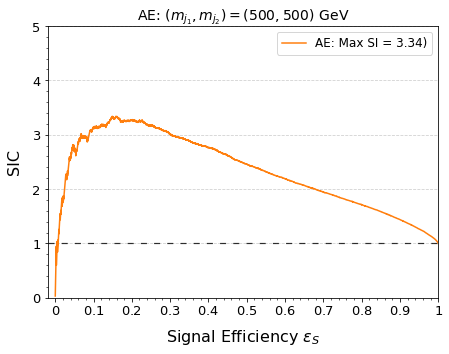

In [16]:
# Plot SIC curve

fig = plt.figure(figsize=(7,5))

# Plot individual SIC surves
plt.plot(tpr500, tpr500/np.sqrt(fpr500), marker='o', markersize=0, linestyle='-', linewidth=1.5, color='C1', 
         alpha=1, label="AE: Max SI = %.2f)" % max_SIC_m500)

# Plot limit of no improvement
plt.axhline(1, dashes=[5,6], color='black', linewidth=1.2, alpha=0.8)

# Options
plt.title(r'AE: $(m_{j_{1}}, m_{j_{2}}) = (500, 500)$ GeV', fontsize=14)
plt.xlabel(r'Signal Efficiency $\epsilon_{S}$', fontsize=16, labelpad=10)
plt.ylabel(r'SIC', fontsize=16, labelpad=10)
plt.legend(loc='upper right', fontsize=12)
plt.xlim(xmin=-0.02, xmax=1)
plt.ylim(ymin=0, ymax=5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tick_params(labelsize=13)
plt.minorticks_on()

plt.gca().set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.gca().set_xticklabels([r'$0$', r'$0.1$', r'$0.2$', r'$0.3$', r'$0.4$', r'$0.5$',
                           r'$0.6$', r'$0.7$', r'$0.8$', r'$0.9$', r'$1$'], fontsize=13)
# Save figure
plt.savefig("/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/plots_AE/AE_m500_SIC_SR.pdf", 
            bbox_inches = 'tight', pad_inches = 0)
plt.show()

/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


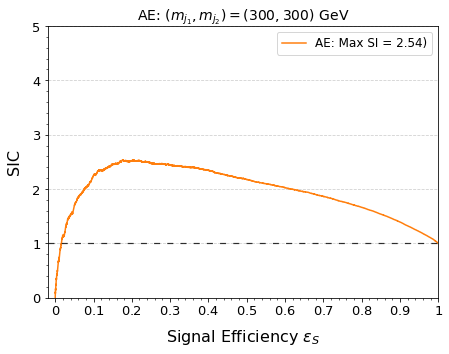

In [17]:
# Plot SIC curve

fig = plt.figure(figsize=(7,5))

# Plot individual SIC surves
plt.plot(tpr300, tpr300/np.sqrt(fpr300), marker='o', markersize=0, linestyle='-', linewidth=1.5, color='C1', 
         alpha=1, label="AE: Max SI = %.2f)" % max_SIC_m300)

# Plot limit of no improvement
plt.axhline(1, dashes=[5,6], color='black', linewidth=1.2, alpha=0.8)

# Options
plt.title(r'AE: $(m_{j_{1}}, m_{j_{2}}) = (300, 300)$ GeV', fontsize=14)
plt.xlabel(r'Signal Efficiency $\epsilon_{S}$', fontsize=16, labelpad=10)
plt.ylabel(r'SIC', fontsize=16, labelpad=10)
plt.legend(loc='upper right', fontsize=12)
plt.xlim(xmin=-0.02, xmax=1)
plt.ylim(ymin=0, ymax=5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tick_params(labelsize=13)
plt.minorticks_on()

plt.gca().set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.gca().set_xticklabels([r'$0$', r'$0.1$', r'$0.2$', r'$0.3$', r'$0.4$', r'$0.5$',
                           r'$0.6$', r'$0.7$', r'$0.8$', r'$0.9$', r'$1$'], fontsize=13)
# Save figure
plt.savefig("/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/plots_AE/AE_m300_SIC_SR.pdf", 
            bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [18]:
# Save preprocessing information for test data
pre_info = np.array([bg_mean, bg_std])

In [19]:
#######################################################################################################
##########################################   Save to file   ###########################################
#######################################################################################################    

#n_background = len(bgdata[5])
#n_signal = len(sigdata[5])
#n_features = 10 + 1

#save_path = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/AE_new_data/'

# Create dataset and classes to store important information
#file_m500 = h5py.File(save_path + 'test_info_m500.hdf5', 'w')

# Save mse distribution and AUC
#bg_data_tofile = file_m500.create_dataset('bg_data', (n_background, n_features), dtype='f8')
#sg_data_tofile = file_m500.create_dataset('sg_data', (n_signal, n_features), dtype='f8')
#mse_bg_tofile = file_m500.create_dataset('mse_bg', (n_background, ), dtype='f8')
#mse_sg_tofile = file_m500.create_dataset('mse_sg', (n_signal, ), dtype='f8')
#pre_info_tofile = file_m500.create_dataset('preprocessing', (2, n_features-1), dtype='f8')

# Fill dataset
#bg_data_tofile[:] = bgdata[5]
#sg_data_tofile[:] = sigdata[5]
#mse_bg_tofile[:] = mse_bg_final_avg
#mse_sg_tofile[:] = mse_sig_final_avg
#pre_info_tofile[:] = pre_info

#file_m500.close()


# Create dataset and classes to store important information
#file_m300 = h5py.File(save_path + 'test_info_m300.hdf5', 'w')

# Save mse distribution and AUC
#bg_data_tofile = file_m300.create_dataset('bg_data', (n_background, n_features), dtype='f8')
#sg_data_tofile = file_m300.create_dataset('sg_data', (n_signal, n_features), dtype='f8')
#mse_bg_tofile = file_m300.create_dataset('mse_bg', (n_background, ), dtype='f8')
#mse_sg_tofile = file_m300.create_dataset('mse_sg', (n_signal, ), dtype='f8')
#pre_info_tofile = file_m300.create_dataset('preprocessing', (2, n_features-1), dtype='f8')

# Fill dataset
#bg_data_tofile[:] = bgdata[5]
#sg_data_tofile[:] = sigdata2[5]
#mse_bg_tofile[:] = mse_bg_final_avg
#mse_sg_tofile[:] = mse_sig2_final_avg
#pre_info_tofile[:] = pre_info

#file_m300.close()

In [20]:
# Load input features from file
#h5_results = h5py.File(save_path + 'test_info_m500.hdf5', 'r')

#bg_evs = h5_results['bg_data'][:]
#sg_evs = h5_results['sg_data'][:]
#bg_mse = h5_results['mse_bg'][:]
#sg_mse = h5_results['mse_sg'][:]
#pre = h5_results['preprocessing'][:]

#h5_results.close()

In [21]:
# Define a function that returns a significance level
from fit_utils import perform_fit, perform_fit2
from scipy.stats import poisson, norm, kstest, skewnorm

def Zscorefunc(obs,pred,sigma):
    pred2=pred-sigma**2
    LLR=0.25*(-2*obs+pred2**2/sigma**2+2*sigma**2+
              pred2*(4-np.sqrt(pred2**2+4*obs*sigma**2)/sigma**2)
             -4*obs*np.log((pred2+np.sqrt(pred2**2+4*obs*sigma**2))/(2*obs))
             )
    return np.sqrt(2*LLR)


Importing Jupyter notebook from fit_utils.ipynb


In [22]:
# Define mJJ
mjj_bg=bgdata[5][:,-1]
mjj_sig=sigdata[5][:,-1]
mjj_sig2=sigdata2[5][:,-1]

10
fit params:  [ -2.64017546 145.00792043]
x_signal_cov:  [[53.54889909]]
Z SCORE:  1.0071783763046418
P VALUE:  0.15692453122786953
GOODNESS OF FIT  0.6195612393266349
fit params:  [ 44.7955154  124.77261114]
x_signal_cov:  [[100.28298623]]
Z SCORE:  0
P VALUE:  0.5
GOODNESS OF FIT  0.5132204457479884
25
fit params:  [ -2.64017546 145.00792043]
x_signal_cov:  [[53.54889909]]
Z SCORE:  1.1285582654110728
P VALUE:  0.12954211234725166
GOODNESS OF FIT  0.6195612393266349
fit params:  [ 44.7955154  124.77261114]
x_signal_cov:  [[100.28298623]]
Z SCORE:  0
P VALUE:  0.5
GOODNESS OF FIT  0.5132204457479884
40
fit params:  [ -2.64017546 145.00792043]
x_signal_cov:  [[53.54889909]]
Z SCORE:  1.2495236635441298
P VALUE:  0.1057368019882221
GOODNESS OF FIT  0.6195612393266349
fit params:  [ 44.7955154  124.77261114]
x_signal_cov:  [[100.28298623]]
Z SCORE:  0
P VALUE:  0.5
GOODNESS OF FIT  0.5132204457479884
55
fit params:  [ -2.64017546 145.00792043]
x_signal_cov:  [[53.54889909]]
Z SCORE:  1

fit params:  [ 42.51260981 136.16728421]
x_signal_cov:  [[102.33088016]]
Z SCORE:  1.2374402267004216
P VALUE:  0.10796184617581983
GOODNESS OF FIT  0.5198306828329465
385
fit params:  [ -7.11242075 165.45914966]
x_signal_cov:  [[47.46546411]]
Z SCORE:  3.6742281453086947
P VALUE:  0.00011928474874423056
GOODNESS OF FIT  0.5389055715046098
fit params:  [ 42.51260981 136.16728421]
x_signal_cov:  [[102.33088016]]
Z SCORE:  1.3609641570934914
P VALUE:  0.08676250839119559
GOODNESS OF FIT  0.5198306828329465
400
fit params:  [ -7.67309305 168.04999539]
x_signal_cov:  [[45.97790582]]
Z SCORE:  3.7661901458415663
P VALUE:  8.287878603441268e-05
GOODNESS OF FIT  0.5206932301509871
fit params:  [ 43.02156502 134.47312997]
x_signal_cov:  [[99.22891604]]
Z SCORE:  1.4254395855453545
P VALUE:  0.07701508606092677
GOODNESS OF FIT  0.503511211424742
415
fit params:  [ -7.67309305 168.04999539]
x_signal_cov:  [[45.97790582]]
Z SCORE:  3.7661901458415663
P VALUE:  8.287878603441268e-05
GOODNESS OF FI

fit params:  [ -8.82833245 173.46728174]
x_signal_cov:  [[47.81978192]]
Z SCORE:  6.101882398086778
P VALUE:  5.241325151672527e-10
GOODNESS OF FIT  0.5384306779244263
fit params:  [ 40.33559485 147.53845121]
x_signal_cov:  [[97.91124456]]
Z SCORE:  3.817500035776325
P VALUE:  6.740538384886197e-05
GOODNESS OF FIT  0.4930910658869422
775
fit params:  [ -9.84041331 177.87690191]
x_signal_cov:  [[45.98184101]]
Z SCORE:  6.143797832041933
P VALUE:  4.0285685898311385e-10
GOODNESS OF FIT  0.5163857853639354
fit params:  [ 40.33559485 147.53845121]
x_signal_cov:  [[97.91124456]]
Z SCORE:  3.9355867940134566
P VALUE:  4.1496831327592076e-05
GOODNESS OF FIT  0.4930910658869422
790
fit params:  [-10.19789865 179.58349945]
x_signal_cov:  [[46.3094051]]
Z SCORE:  6.113357967256666
P VALUE:  4.877810377834635e-10
GOODNESS OF FIT  0.5190277416285883
fit params:  [ 40.33559485 147.53845121]
x_signal_cov:  [[97.91124456]]
Z SCORE:  4.131869600308762
P VALUE:  1.7991227076574745e-05
GOODNESS OF FIT  

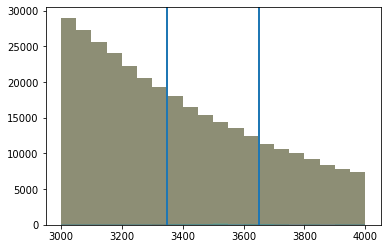

In [23]:
# Fit with full dataset, no cuts
#mask_sr=[3,4]
#def fit_func(y,p0,p1,p2,p3,p4,p5,p6,p7):
#    return np.exp(p0+p1*y+p2*y**2+p3*y**3+p4*y**4+p5*y**5+p6*y**6+p7*y**7)
#def fit_func(x,p0,p1,p2,p3,p4,p5,p6):
#    return (p3+p4*x+p5*x**2+p6*x**3)*skewnorm.pdf((x-p0)/p1,p2)\
#def fit_func(x,p0,p1,p2,p3,p4):
#    return p0*(1-x)**(p1+p4*(np.log(1-x)))/(x**(p2+p3*np.log(x)))

def fit_func(x,p0,p1):
    return p0+p1*x

pvallist_cut_sig=[]
pvallist_cut_sig2=[]
info_m500 = []
info_m300 = []

nbins=20
mask_sr=[7,8,9,10,11,12]
mask_sb=[x for x in range(nbins) if x not in mask_sr] 

for nsig in range(10,895,15):
    print(nsig)
    
    ##########  m = 500 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig_raw,bins,_=plt.hist(mjj_sig[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])
    
    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>maxsiccut_sig],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig,bins,_=plt.hist(mjj_sig[:nsig][mse_sig_final_avg[:nsig]>maxsiccut_sig],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])

    # After cut: define the total number of events (s+b) in each SR bin, and the statistical error in each SR bin
    ydata=(counts_bg+counts_sig).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')

    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    # Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m500 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m500.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after])
    
    ##########  m = 300 GeV  ##########

    # Before cut: define bins and count number of signal and background events in each bin
    counts_bg_raw,bins,_=plt.hist(mjj_bg,range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2_raw,bins,_=plt.hist(mjj_sig2[:nsig],range=[3000,4000],bins=nbins,alpha=0.3)
    # Before cut: count number of signal and background events in the SR
    Sinit=np.sum(counts_sig2_raw[mask_sr])
    Binit=np.sum(counts_bg_raw[mask_sr])

    # After cut: define bins and count number of signal and background events in each bin
    counts_bg,bins,_=plt.hist(mjj_bg[mse_bg_final_avg>maxsiccut_sig2],range=[3000,4000],bins=nbins,alpha=0.3)
    counts_sig2,bins,_=plt.hist(mjj_sig2[:nsig][mse_sig2_final_avg[:nsig]>maxsiccut_sig2],range=[3000,4000],bins=nbins,alpha=0.3)
    # After cut: count number of signal and background events in the SR
    Safter=np.sum(counts_sig2[mask_sr])
    Bafter=np.sum(counts_bg[mask_sr])
    
    # After cut: define the total number of events (s+b) in each bin, and the statistical error in each bin
    ydata=(counts_bg+counts_sig2).astype('float64')
    yerr=np.sqrt(counts_bg+counts_sig2).astype('float64')
    xdata=(0.5*(bins[:-1]+bins[1:])/14000).astype('float64')
    plt.axvline(bins[mask_sr[0]])
    plt.axvline(bins[mask_sr[-1]+1])

    # Make the fit
    popt,pcov,ydata_fit,pval = perform_fit(ydata,yerr,xdata,fit_func,mask_sb,mask_sr)
    
    #Check that the function is a good fit to the sideband
    residuals = (ydata - ydata_fit)/yerr
    redchisq=np.sum((residuals[mask_sb])**2/(len(mask_sb)-len(popt)))
    print("GOODNESS OF FIT ",redchisq)
    pvallist_cut_sig2.append([nsig,Sinit/Binit,Sinit/np.sqrt(Binit),pval,norm.ppf(1-pval), Safter/np.sqrt(Bafter)])
    
    # Save useful information
    S_B = Sinit/Binit
    S_sqrt_B_initial = Sinit/np.sqrt(Binit)
    S_sqrt_B_after = Safter/np.sqrt(Bafter)
    pval_expected_initial = 1-norm.cdf(S_sqrt_B_initial)
    pval_expected_after = 1-norm.cdf(S_sqrt_B_after)
    selection_m300 = (Safter + Bafter)/(Sinit + Binit)*100
    
    info_m300.append([S_B, S_sqrt_B_initial, S_sqrt_B_after, pval, pval_expected_initial, pval_expected_after])

# Transform lists to arrays
info_m500 = np.array(info_m500)
info_m300 = np.array(info_m300)

In [24]:
print('Event selection for m500: %.2f%%' % selection_m500)
print('Event selection for m300: %.2f%%' % selection_m300)

Event selection for m500: 0.36%
Event selection for m300: 0.63%


Text(0, 0.5, 'p value')

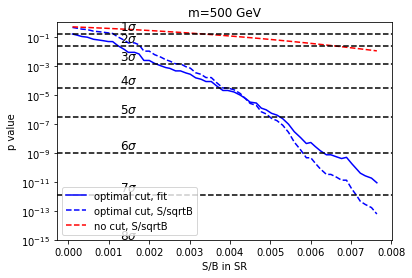

In [26]:
# Make plot
plt.plot(info_m500[:,0], info_m500[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m500[:,0], info_m500[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m500[:,0], info_m500[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')
for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=500 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

Text(0, 0.5, 'p value')

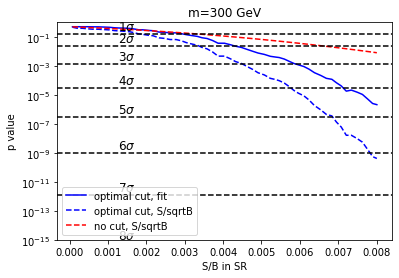

In [27]:
# Make plot
plt.plot(info_m300[:,0], info_m300[:,3], label='optimal cut, fit',color='blue')
plt.plot(info_m300[:,0], info_m300[:,5], label='optimal cut, S/sqrtB',color='blue',ls='dashed')
plt.plot(info_m300[:,0], info_m300[:,4], label='no cut, S/sqrtB',color='red',ls='dashed')
for sigma in range(1,9):
    plt.axhline(1-norm.cdf(sigma),linestyle='dashed',color='black')
    sigmastring = r'$' + str(sigma) + '\sigma$'
    plt.text(0.0015,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=12)

plt.yscale('log')
plt.ylim(1e-15,1)
plt.title('m=300 GeV')
plt.legend()
plt.xlabel('S/B in SR')
plt.ylabel('p value')

In [28]:
#######################################################################################################
##########################################   Save to file   ###########################################
#######################################################################################################    

save_path = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/AE_new_data/'

# Create dataset and classes to store important information
file_m500 = h5py.File(save_path + 'AE_pvalues_info_m500.hdf5', 'w')

# Save mse distribution and AUC
fit_info_tofile = file_m500.create_dataset('fit_m500', info_m500.shape, dtype='f8')

# Fill dataset
fit_info_tofile[:] = info_m500

file_m500.close()


# Create dataset and classes to store important information
file_m300 = h5py.File(save_path + 'AE_pvalues_info_m300.hdf5', 'w')

# Save mse distribution and AUC
fit_info_tofile = file_m300.create_dataset('fit_m300', info_m300.shape, dtype='f8')

# Fill dataset
fit_info_tofile[:] = info_m300

file_m300.close()